# Gradient Descent: Part I

One cannot overstate the importance "Gradient descent" in the field of machine learning. It's an optimization technique that lies in the heart of machine learning algorithm ranging from regression to deep learning. This chapter aims to provide intuition behind the gradient descent algorithm and it's variant. Similar to previous chapters, I work through examples and code in order to build a concrete understanding of the concept. 

## Finding Minimum Using Brute Force
Assume a two dimensional function $f(X)=x_0^2 + x_1^2$. Now let's assume we want to find the value of $X=(x_0, x_1)$ at which f(X) is minimum. A natural instinct would be to plot the function for some random range of X and observe the behavior of $f(X)$. Using plotly, below code snippet renders the above function. 

,x0,x1,fx
0,-50.0,-49.0,4901.0
1,-49.0,-50.0,4901.0
2,-50.0,-48.0,4804.0
3,-48.0,-50.0,4804.0


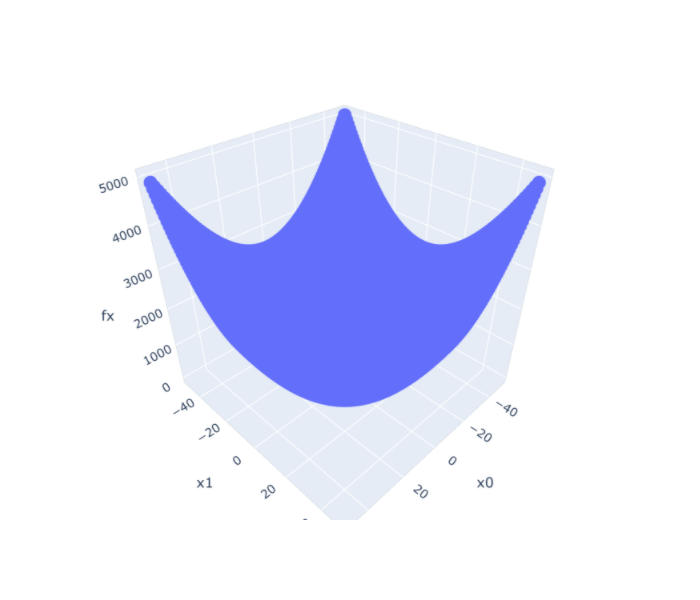

In [3]:
import random
import pandas as pd
import numpy as np
import math
from copy import copy
import itertools

def func(x):
    """the function we are trying to minimize"""
    return math.pow(x[0], 2) + math.pow(x[1],2)


def point_generator(choices, func):
    """Generates all possible combinations of X and returns X and f(x) values"""
    
    for pt in itertools.combinations(choices, 2):
        pt = list(pt)
        yield(pt + [func(pt)])
        
        pt.reverse()
        yield(pt + [func(pt)])
        
    # generate diagonals
    for x in choices:
        pt = [x, x]
        yield(pt + [func(pt)])
    
    
choices = np.array(range(-500, 500, 10))/10.
df = (
    pd
    .DataFrame(list(point_generator(choices, func)), columns=['x0', 'x1', 'fx'])
)
display(df.head(4))

from chart_studio.plotly import plot
import plotly.express as px
fig = px.scatter_3d(df, x='x0', y='x1', z='fx', )
image = fig.to_image(format='png')
from IPython.display import Image
Image(image)
# fig.show() -- use this command for generating interactive image

From the above plot, one can easily observe that $f(X)$ reaches a minimum value when $X = [0, 0]$ (i.e $x_1 = 0$ and $x_2 = 0$). 

As humans, we can do this naturally as long as we can visualize the function.  However, a typical machine learning problem will involve hundreds of features. So let's think how did we so easily find the point X at which $f(X)$ is minimum. One possible explanation is that our eyes randomly picked a point on the above surface and followed in the direction where the slope is decreasing. Finally, when the slop starts increasing again we know that we have crossed the minimum point. Let's try to transfer this idea into a proper python code. The logical flow of the problem will be as follows:

**Step 1:** Pick a random point $X = (x_0, x_1)$
**Step 2:** Identify the next point $X'$ such as that $f(X') < f(X)$. However, one challenge is how do we find $X'$. Let's start with some brute force. Assume we look for neighboring points that are $\eta$ distance away on a single dimension.  For instance, as shown below figure (a), let's assume $X=[1,1]$ and $\eta = 0.25$. Then, the neighboring points to explore are [1-0.25, 1], [1 + 0.25, 1], [1, 1-0.25], [1, 1 + 0.25]. Thus, if X is n dimensional vector then there will be $2^n$ neighbors to explore. If we relax the constraint that one can only move $\eta$ distance along on one dimension at any given time, then we have additional four diagonal points as shown in the figure: [1-0.25, 1-0.25], [1+0.25, 1-0.25], [1-0.25, 1+0.25], [1+0.25, 1+0.25]. For n dimensional space then there will be $3^n$ neighboring points.

![](images/Chapter3_NeighboringPoints.png)

Ignoring the scalability issue for now, let's assume we do use the above approach to generate possible neighboring candidates at which we need to evaluate $f(X)$.

**Step 3:** Of all neighboring points at which $f(X') < f(X)$, pick the one with the maximum difference and set this new point around which we explore the space. 

**Step 4**: Repeat step 2 and 3 until one reaches the point where $f(X') > f(X)$ for all neighboring point. 

The below python code implements the above logic. It assumes $\eta$ to be 0.03 

In [ ]:
from collections import namedtuple
import math
from IPython.display import HTML
from itertools import product
import numpy as np

# we will use Point class to store x and assocated y values
Point = namedtuple('Point', ['x', 'y'])


def func(x):
    """the function we are trying to minimize"""
    return math.pow(x[0], 2) + math.pow(x[1],2)

class Point(object):
    
    def __init__(self, X):
        self._x = X
        
    @property
    def x(self):
        return self._x
    
    def neighbors(self, distance=0.25):
            """For a given point, generate all the neighbors 
            by walking delta distance along a single dimension only
            """
            pts = [
                np.array(self.x) - distance,
                np.array(self.x) + distance
            ]
            return [Point(x2) for x2 in product(*np.transpose(pts).tolist())]
    
    def __repr__(self):
        return str(self)
    
    def __str__(self):
        return "{}".format(self.x)
    
    def __eq__(self, other):
        return self.x == other.x
        

def minimize_v1(func, start_point, eta = 0.03, max_iterations = 1000, traceback = None):
    
    x1 = Point(start_point)
    y1 = func(x1.x)    
    
    for iter in range(max_iterations):
        
        if traceback:
            traceback.append(x1.x)


        # generate neighbors at distance of eta
        neighbors = x1.neighbors(eta)
        
        # Identify next point where the f(x) is smallest
        min_x = x1
        min_y = y1     
        
        for x2 in neighbors:    
            y2 = func(x2.x)
            if y2 < min_y:
                min_x, min_y = x2, y2
        
        
        # if x2 is same as x1 then we are at minimum
        if x1 == min_x:
            return x1.x
        
        x1, y1 = min_x, min_y
        
    # if we reached max iterations then return current point
    return x1.x
    

minPt = minimize_v1(func, [100, 100], eta=0.03, max_iterations=5000)
display(HTML("<strong>Optimal {}</strong>".format(minPt, iter)))


In [ ]:
%%timeit 
minimize_v1(func, [100, 100], eta=0.03, max_iterations=5000)

## Using Gradient Approach
Great, now we have working function. But it's not scalable. If you have n dimensionals pace, there are $3^n$ possible neighbors that we need to explore (this is assuming that we are taking $\eta$ distance along each dimension). One way to solve the above scalability issue is use the concept of directional derivative and gradients. 

The main objective of step 2 is to find $X'$ for which $f(X')$ is smallest. This is exactly the kind of information that derivative provides. For instance, our function $f(X)=x_0^2 + x_1^2$ has two parameters: $x_0, x_1$. So partial derivative of our function $f(x)$, written as $\Delta{f(X)}$ is given as:

$$\Delta{f(X)} = \begin{bmatrix}
\frac{\partial{f}}{\partial{x_0}}\\ 
\frac{\partial{f}}{\partial{x_1}}
\end{bmatrix} = \begin{bmatrix}
2x_0\\
2x_1
\end{bmatrix}$$

The partial derivative gives the direction of steepest gradient. Since we are interested in minimization, we want to move opposite to the direction of greatest gradient. Thus, rather than having to explore $3^n$ points, we can essentially find $X'$ using the below formula

$$ X' = X - \eta \Delta{f(X)}$$


There are two things to note in the above equation:

1. $\Delta{f(X)}$ gives the direction of steepest gradient. Since we want to minimize, we want to go in the opposite direction of steepest gradient and hence "minus" sign. 
2. $\Delta{f(X)}$ is a unit vector. If we directly do $X - \Delta{f(X)}$ then we are finding neighbors in opposite direction of steepest gradient that is at a distance of one unit from the current point X. A jump of one unit might be too much and hence we dampen it by multipling by $\eta$. Often **$\eta$ is referreed as the learning rate**.


Using the gradient approach, let's write the second version of minimization method. Note that below, the func now doesn't refer to the original function ($x_0^2 + x_1^2$) but to it's derivative i.e. ($2x_0 + 2x1$).



In [ ]:
from copy import copy

def func_gradient(x):
    assert len(x) == 2
    return np.array([
        2. * x[0],
        2 * x[1]
    ])


def minimize_v2(func, start_point, eta = 0.03, max_iterations = 1000, traceback = None):
    
    x1 = start_point
    
    for iter in range(max_iterations):
        
        if traceback is not None:
            traceback.append(copy(x1))

        x1 -= eta * np.array(func(x1))
        
    # if we reached max iterations then return current point
    return x1



minPt = minimize_v2(func_gradient, [100, 100], eta=0.03, max_iterations=5000)
display(HTML("<strong>Optimal {}</strong>".format(minPt, iter)))




In [ ]:
%%timeit 
minPt = minimize_v2(func_gradient, [100, 100], eta=0.03, max_iterations=5000)

## Stopping Criteria

if you compare v1 and v2 implementation, you will notice that using the gradient approach significantly simplified our logic. But in theory it should also make it much more scalable and faster. One important detail that I skipped and affects the performance of the gradient based approach is **stopping criteria**. Currently the only way `minimize_v2` can stop is when it reaches maximum number of iterations. If you plot the traceback, as shown below, you will notice that the x2 doesn't change much after 500 iterations.

In [ ]:
traceback = []
minPt = minimize_v2(func_gradient, [100, 100], eta=0.03, max_iterations=5000, traceback = traceback)
print ("Optimal point is {}".format(minPt))

In [ ]:
# convert traceback into a data frame for plotting purpose
df = pd.DataFrame(traceback, columns=['x1', 'x2'])
df['iteration'] = list(range(1, df.shape[0]+1))
df = df.melt(id_vars='iteration', value_vars=['x1', 'x2'])

from plotnine import *
%matplotlib inline
(
    ggplot(df[df['iteration'] % 250 == 0], aes(x='iteration', y='value'))
    + geom_line(aes(group='variable', color='variable'))
    + facet_wrap("~variable", nrow=2)
    + xlab("Iteration Number")
    + ylab("Value")
    + theme_linedraw()
    + theme(figure_size=(20, 8))
)

Thus, one way to speed up things is to introduce a stopping criteria. Let's assume we stop as soon as the euclidean distance between x1 and x2 is less than some threshold, say 1e-6. Minimize V3 adds this stopping criteria. 

In [ ]:
from copy import copy
from scipy.spatial import distance

def func_gradient(x):
    assert len(x) == 2
    return np.array([
        2. * x[0],
        2 * x[1]
    ])


def minimize_v3(func, start_point, eta = 0.03, max_iterations = 1000, traceback = None, stopping_threshold = 1.0e-6):
    
    x1 = start_point
    
    for iter in range(max_iterations):
        
        if traceback is not None:
            traceback.append(copy(x1))

        x2  = x1 - eta * np.array(func(x1))
        
        # check if we reached stopping criteria threshold
        if distance.euclidean(x2, x1) < stopping_threshold:
            return x2
        else:
            x1 = x2
        
    # if we reached max iterations then return current point
    return x1


traceback = []
minPt = minimize_v3(func_gradient, [100, 100], eta=0.03, max_iterations=5000, traceback=traceback, stopping_threshold=1.0e-6)
display(HTML("<strong>Optimal {}</strong>".format(minPt, iter)))
display(HTML("Total Number of Iterations: {}".format(len(traceback))))



In [ ]:
%%timeit 
minPt = minimize_v3(func_gradient, [100, 100], eta=0.03, max_iterations=5000)

As you can notice above, we reached reasonably close to the optimal point (0, 0) in just 259 iterations and the performance increased 5x. The mean time reduced from 23 ms to 5 ms in my runs.

## More things to consider
Gradient descent algorithm is still an active area of research. There are many aspects of the algorithm that influences its performance both in terms of running time and accuracy. For instance, I didn't really talk much about the impact of learning rate on the performance and accuracy of the gradient descent approach. A small learning rate increases running time but improves accuracy and vice-versa. However, learning rate doesn't have to constant. There are many variants of the gradient descent algorithm where learning rate is dynamically modified based on number of iteration, steepness of gradient, etc. Hence, I would recomment think about following things:

1. Different types of stopping criterias
2. Impact of learning rate on performance and accuracy. 
3. How to make learning rate auto adjust (search for "Momentum" gradient descent)
4. Automatically deriving partial derivative of a given function (checkout "autograd" library)

In the next chapter, I will show this idea of gradient descent is used in linear regression.
